# Кошелев Александр

# Imports

In [1]:
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod
from loguru import logger
from collections import defaultdict
from copy import deepcopy
import numpy as np

In [2]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

In [3]:
class BlackJackGamer(ABC):
    
    def __init__(self, env, epsilon) -> None:
        self.env = env
        self.epsilon = epsilon
        
    @abstractmethod
    def run_episode(self):
        ...
             
    @abstractmethod
    def policy(self, observation, epsilon) -> int:
        ...
        
    @abstractmethod
    def evaluate_episode(self):
        ...

# Пункт 1

In [4]:
env = gym.make("Blackjack-v1")
env.reset()

(12, 4, False)

## Simple Player

In [5]:
class SimplePlayer(BlackJackGamer):
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards
            
    def policy(self, observation, epsilon=0) -> int:
        score, dealer_score, usable_ace = observation
        return 0 if score >= 19 else 1
    
    def evaluate_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation, 0)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards 

In [6]:
simple_player = SimplePlayer(env, 0)

In [7]:
states, actions, rewards = simple_player.run_episode()

In [8]:
gain = []
for _ in range(300000):
    states, actions, rewards = simple_player.run_episode()
    gain.append(rewards[-1])

In [9]:
gain_eval = []
for _ in range(100000):
    states, actions, rewards = simple_player.evaluate_episode()
    gain_eval.append(rewards[-1])

In [10]:
np.mean(gain_eval)

-0.19673

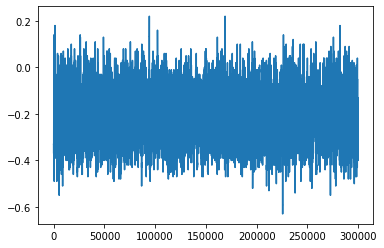

In [11]:
# plt.plot(gain_n.mean(axis=dd1)[:100])
plt.plot(moving_average(gain, 100))

## Q-learning Player

In [12]:
class QLearningPlayer(BlackJackGamer):
    
    def __init__(self, env, epsilon, lr, gamma) -> None:
        super(QLearningPlayer, self).__init__(env, epsilon)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        
    def init_random_Q(self):
        self.Q = {}
        for i in range(12):
            self.Q[i] = np.array([0, 1])
        for i in range(22, 32):
            self.Q[i] = np.array([0, 0])
        for i in range(12, 22):
            self.Q[i] = np.random.random(2)
        self.Q[21][1] = 0
        self.Q[21][0] = 1
        
            
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __ = observation 
        action = self.policy(observation, self.epsilon)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            s_prime, _, __ = observation
            a_prime = self.policy(observation, self.epsilon)
            if s > 12 and s < 21:
                self.Q[s][action] = self.Q[s][action] + self.lr * (reward + self.gamma * np.max(self.Q[s_prime]) - self.Q[s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation, epsilon=0.1) -> int:
        score, dealer_score, usable_ace = observation
        if score > 21:
            return 0
        if np.random.random() < epsilon:
            return np.random.choice([0, 1]) 
        return np.argmax(self.Q[score])
    
    def evaluate_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation, 0)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards 

In [13]:
qlearningplayer = QLearningPlayer(env, 0.1, 0.0001, 0.8)

In [14]:
qlearningplayer.init_random_Q()

In [15]:
gain = []
for _ in range(300000):
    states, actions, rewards = qlearningplayer.run_episode()
    gain.append(rewards[-1])

In [16]:
gain_eval = []
for _ in range(100000):
    states, actions, rewards = qlearningplayer.evaluate_episode()
    gain_eval.append(rewards[-1])

In [17]:
np.mean(gain_eval)

-0.1225

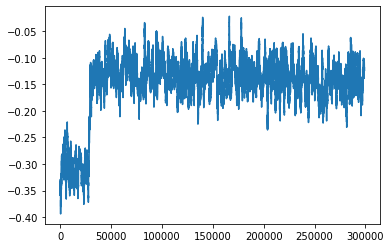

In [18]:
plt.plot(moving_average(gain, 1000))

In [19]:
best_gain = -1
for epsilon in [0.1, 0.2]:
    for lr in [0.0001, 0.001, 0.01, 0.1]:
        for gamma in [0.4, 0.8]:
            qlearningplayer = QLearningPlayer(env, epsilon, lr, gamma)
            qlearningplayer.init_random_Q()
            gain = []
            eval_gain = []
            for _ in range(500000):
                states, actions, rewards = qlearningplayer.run_episode()
                gain.append(rewards[-1])
            for _ in range(100000):
                states, actions, rewards = qlearningplayer.evaluate_episode()
                eval_gain.append(rewards[-1])
            mean_gain = np.mean(eval_gain)
            print(f"epsilon {epsilon} LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
            if mean_gain > best_gain:
                best_gamma = gamma
                best_lr = lr
                best_gain = mean_gain
                best_epsilon = epsilon
print(f"BEST epsilon {best_epsilon} LR: {best_lr}, Gamma: {best_gamma}, mean gain {best_gain}")

epsilon 0.1 LR: 0.0001, Gamma: 0.4, mean gain -0.07578
epsilon 0.1 LR: 0.0001, Gamma: 0.8, mean gain -0.1207
epsilon 0.1 LR: 0.001, Gamma: 0.4, mean gain -0.0749
epsilon 0.1 LR: 0.001, Gamma: 0.8, mean gain -0.10801
epsilon 0.1 LR: 0.01, Gamma: 0.4, mean gain -0.11608
epsilon 0.1 LR: 0.01, Gamma: 0.8, mean gain -0.10766
epsilon 0.1 LR: 0.1, Gamma: 0.4, mean gain -0.11038
epsilon 0.1 LR: 0.1, Gamma: 0.8, mean gain -0.10273
epsilon 0.2 LR: 0.0001, Gamma: 0.4, mean gain -0.08201
epsilon 0.2 LR: 0.0001, Gamma: 0.8, mean gain -0.11016
epsilon 0.2 LR: 0.001, Gamma: 0.4, mean gain -0.08905
epsilon 0.2 LR: 0.001, Gamma: 0.8, mean gain -0.11464
epsilon 0.2 LR: 0.01, Gamma: 0.4, mean gain -0.09047
epsilon 0.2 LR: 0.01, Gamma: 0.8, mean gain -0.10471
epsilon 0.2 LR: 0.1, Gamma: 0.4, mean gain -0.12062
epsilon 0.2 LR: 0.1, Gamma: 0.8, mean gain -0.20096
BEST epsilon 0.1 LR: 0.001, Gamma: 0.4, mean gain -0.0749


## Выводы пункт 1

Средний проигрыш наивного игрока 0.2 <br>
Средний проигрыш Qlearning игрока (с параметрами epsilon=0.1, lr=0.001, gamma=0,4) 0.0749 <br>

# Пункт 2

In [20]:
class QDoublePlayer(BlackJackGamer):
    
    def __init__(self, env, epsilon, lr, gamma) -> None:
        super(QDoublePlayer, self).__init__(env, epsilon)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        self.last_action = 0
        
    def init_random_Q(self):
        self.Q = {}
        for i in range(12):
            self.Q[i] = np.array([0, 1, 0])
        for i in range(22, 32):
            self.Q[i] = np.array([0, 0, 0])
        for i in range(12, 22):
            self.Q[i] = np.random.random(3)
        self.Q[21][2] = 0
        self.Q[21][1] = 0
        self.Q[21][0] = 1
        
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __ = observation 
        action = self.policy(observation, self.epsilon)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.new_step(action)
            s_prime, _, __ = observation
            a_prime = self.policy(observation, self.epsilon)
            if s > 12 and s < 21:
                self.Q[s][action] = self.Q[s][action] + self.lr * (reward + self.gamma * np.max(self.Q[s_prime]) - self.Q[s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation, epsilon=0.1) -> int:
        score, dealer_score, usable_ace = observation
        if self.last_action == 2:
            action = 0
        else:
            if np.random.random() < epsilon:
                action = np.random.choice([0, 1, 2])
            else:
                action = np.argmax(self.Q[score])
        self.last_action = action
        return action
    
    def new_step(self, action):
        action_for_env = action if action != 2 else 1
        observation, reward, done, info = self.env.step(action_for_env)
        if action == 2:
            reward *= 2
        return observation, reward, done, info
    
    def evaluate_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation, 0)
            actions.append(action)
            observation, reward, done, info = self.new_step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards 

In [21]:
qdoubleplayer = QDoublePlayer(env, 0.1, 0.001, 0.8)
qdoubleplayer.init_random_Q()
gain = []
for _ in range(300000):
    states, actions, rewards = qdoubleplayer.run_episode()
    gain.append(rewards[-1])

In [22]:
gain_eval = []
for _ in range(100000):
    states, actions, rewards = qdoubleplayer.evaluate_episode()
    gain_eval.append(rewards[-1])

np.mean(gain_eval)

-0.1407

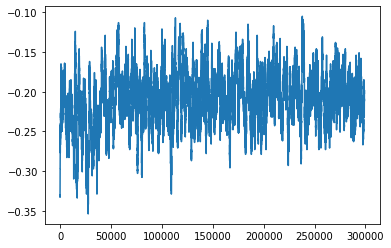

In [23]:
plt.plot(moving_average(gain, 1000))

In [24]:
best_gain = -1
for epsilon in [0.1, 0.2]:
    for lr in [0.0001, 0.001, 0.01, 0.1]:
        for gamma in [0.4, 0.8]:
            qdoubleplayer = QDoublePlayer(env, epsilon, lr, gamma)
            qdoubleplayer.init_random_Q()
            gain = []
            eval_gain = []
            for _ in range(500000):
                states, actions, rewards = qdoubleplayer.run_episode()
                gain.append(rewards[-1])
            for _ in range(100000):
                states, actions, rewards = qdoubleplayer.evaluate_episode()
                eval_gain.append(rewards[-1])
            mean_gain = np.mean(eval_gain)
            print(f"epsilon {epsilon} LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
            if mean_gain > best_gain:
                best_gamma = gamma
                best_lr = lr
                best_gain = mean_gain
                best_epsilon = epsilon
print(f"BEST epsilon {best_epsilon} LR: {best_lr}, Gamma: {best_gamma}, mean gain {best_gain}")

epsilon 0.1 LR: 0.0001, Gamma: 0.4, mean gain -0.08797
epsilon 0.1 LR: 0.0001, Gamma: 0.8, mean gain -0.10259
epsilon 0.1 LR: 0.001, Gamma: 0.4, mean gain -0.07308
epsilon 0.1 LR: 0.001, Gamma: 0.8, mean gain -0.12161
epsilon 0.1 LR: 0.01, Gamma: 0.4, mean gain -0.11365
epsilon 0.1 LR: 0.01, Gamma: 0.8, mean gain -0.11652
epsilon 0.1 LR: 0.1, Gamma: 0.4, mean gain -0.14431
epsilon 0.1 LR: 0.1, Gamma: 0.8, mean gain -0.22614
epsilon 0.2 LR: 0.0001, Gamma: 0.4, mean gain -0.11477
epsilon 0.2 LR: 0.0001, Gamma: 0.8, mean gain -0.1151
epsilon 0.2 LR: 0.001, Gamma: 0.4, mean gain -0.07548
epsilon 0.2 LR: 0.001, Gamma: 0.8, mean gain -0.14231
epsilon 0.2 LR: 0.01, Gamma: 0.4, mean gain -0.11625
epsilon 0.2 LR: 0.01, Gamma: 0.8, mean gain -0.10868
epsilon 0.2 LR: 0.1, Gamma: 0.4, mean gain -0.12155
epsilon 0.2 LR: 0.1, Gamma: 0.8, mean gain -0.11053
BEST epsilon 0.1 LR: 0.001, Gamma: 0.4, mean gain -0.07308


## Выводы пункт 2

Средний проигрыш Qdouble игрока (с параметрами epsilon=0.1, lr=0.001, gamma=0,4) 0.07308 <br>

# Пункт 3

В этот раз не получилось воспользоваться готовой средой, поэтому возьмем из задания. Для подсчета карт использовал стратегию  «Плюс-минус»  https://ru.wikipedia.org/wiki/%D0%91%D0%BB%D1%8D%D0%BA%D0%B4%D0%B6%D0%B5%D0%BA

In [25]:
def cmp(a, b):
    return float(a > b) - float(a < b)

class BlackjackDoubleCountingEnv(gym.Env):
    
    def __init__(self):
        self.plus_minus_count = {
            2: 1,
            3: 1,
            4: 1,
            5: 1,
            6: 1,
            7: 0,
            8: 0,
            9: 0,
            10: -1,
            11: -1,
        }
        self.action_space = spaces.Discrete(3)
        self.observation_space = spaces.Tuple((
            spaces.Discrete(32),
            spaces.Discrete(11),
            spaces.Discrete(2),
            spaces.Discrete(42)))
        self.seed()
        self.full_deck = [2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10, 11] * 4
        self.deck = deepcopy(self.full_deck)
        self.count = 0
        self.reset()


    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]


    def step(self, action):
        assert self.action_space.contains(action)
        if action == 1:  # hit: add a card to players hand and return
            card = self.draw_card()
            self.count_card(card)
            self.player.append(card)
            if self.is_bust(self.player):
                done = True
                reward = -1.
            else:
                done = False
                reward = 0.
        elif action == 0:
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            for card in self.dealer[1:]:
                self.count_card(card)
            reward = cmp(self.score(self.player), self.score(self.dealer))

        elif action == 2:
            card = self.draw_card()
            self.count_card(card)
            self.player.append(card)
            done = True
            while self.sum_hand(self.dealer) < 17:
                self.dealer.append(self.draw_card())
            for card in self.dealer[1:]:
                self.count_card(card)
            reward = cmp(self.score(self.player), self.score(self.dealer)) * 2
            
        return self._get_obs(), reward, done, {}

    def _get_obs(self):
        return (self.sum_hand(self.player), self.dealer[0], False, self.count)
    
    def count_card(self, card):
        self.count += self.plus_minus_count[card] 

    def reset(self):
        if len(self.deck) < 15:
            self.deck = deepcopy(self.full_deck)
            self.count = 0
        self.dealer = self.draw_hand()
        self.count_card(self.dealer[0])
        self.player = self.draw_hand()
        self.count_card(self.player[0])
        self.count_card(self.player[1])
        return self._get_obs()
    
    def draw_card(self):
        card = np.random.choice(self.deck)
        self.deck.remove(card)
        return card


    def draw_hand(self):
        return [self.draw_card(), self.draw_card()]
    
    @staticmethod
    def sum_hand(hand):
        return sum(hand)
    
    def is_bust(self, hand):  # Is this hand a bust?
        return self.sum_hand(hand) > 21
    
    def score(self, hand):  # What is the score of this hand (0 if bust)
        return 0 if self.is_bust(hand) else self.sum_hand(hand)

In [26]:
custom_env = BlackjackDoubleCountingEnv()

In [27]:
custom_env.reset()

(14, 10, False, 1)

In [28]:
class QDustinPlayer(BlackJackGamer):
    
    def __init__(self, env, epsilon, lr, gamma) -> None:
        super(QDustinPlayer, self).__init__(env, epsilon)
        self.Q = {}
        self.lr = lr
        self.gamma = gamma
        self.last_action = 0
        
    def init_random_Q(self):
        self.Q = defaultdict(dict)
        for counter in range(-22, 23):
            for i in range(12):
                self.Q[counter][i] = np.array([0, 1, 0])
            for i in range(22, 32):
                self.Q[counter][i] = np.array([0, 0, 0])
            for i in range(12, 22):
                self.Q[counter][i] = np.random.random(3)
            self.Q[counter][21][2] = 0
            self.Q[counter][21][1] = 0
            self.Q[counter][21][0] = 1
        
    
    def run_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        s, _, __, cnt = observation 
        action = self.policy(observation, cnt, epsilon)
        while True:
            states.append(s)        
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            s_prime, _, __, cnt = observation
            a_prime = self.policy(observation, cnt, epsilon)
            if s > 12 and s < 21:
                self.Q[cnt][s][action] = self.Q[cnt][s][action] + self.lr * (reward + self.gamma * np.max(self.Q[cnt][s_prime]) - self.Q[cnt][s][action])
            s, action = s_prime, a_prime
            rewards.append(reward)
            if done:
                return states, actions, rewards              
    
    def policy(self, observation, count, epsilon=0.1) -> int:
        score, dealer_score, usable_ace, _ = observation
        if score > 21:
            return 0
        if np.random.random() < epsilon:
            return np.random.choice([0, 1, 2]) 
        return np.argmax(self.Q[count][score])
    
    def evaluate_episode(self):
        states, actions, rewards = [], [], []
        observation = self.env.reset()
        while True:
            states.append(observation)
            action = self.policy(observation, observation[-1], 0)
            actions.append(action)
            observation, reward, done, info = self.env.step(action)
            rewards.append(reward)
            if done:
                return states, actions, rewards 
    

In [29]:
dustin = QDustinPlayer(custom_env, 0.1, 0.001, 0.4)

In [30]:
dustin.init_random_Q()

In [31]:
gain = []
for _ in range(300000):
    states, actions, rewards = dustin.run_episode()
    gain.append(rewards[-1])

In [32]:
gain_eval = []
for _ in range(100000):
    states, actions, rewards = dustin.evaluate_episode()
    gain_eval.append(rewards[-1])

np.mean(gain_eval)

-0.13589

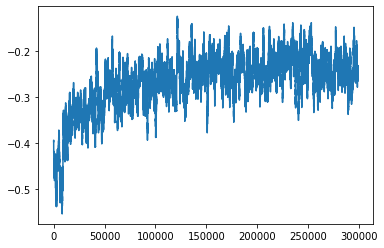

In [33]:
plt.plot(moving_average(gain, 1000))

In [34]:
best_gain = -1
for epsilon in [0.1, 0.2]:
    for lr in [0.0001, 0.001, 0.01, 0.1]:
        for gamma in [0.4, 0.8]:
            dustin = QDustinPlayer(custom_env, epsilon, lr, gamma)
            dustin.init_random_Q()
            gain = []
            eval_gain = []
            for _ in range(3000000):
                states, actions, rewards = dustin.run_episode()
                gain.append(rewards[-1])
            for _ in range(100000):
                states, actions, rewards = dustin.evaluate_episode()
                eval_gain.append(rewards[-1])
            mean_gain = np.mean(eval_gain)
            print(f"epsilon {epsilon} LR: {lr}, Gamma: {gamma}, mean gain {mean_gain}")
            if mean_gain > best_gain:
                best_gamma = gamma
                best_lr = lr
                best_gain = mean_gain
                best_epsilon = epsilon
print(f"BEST epsilon {best_epsilon} LR: {best_lr}, Gamma: {best_gamma}, mean gain {best_gain}")

epsilon 0.1 LR: 0.0001, Gamma: 0.4, mean gain -0.13024
epsilon 0.1 LR: 0.0001, Gamma: 0.8, mean gain -0.13237
epsilon 0.1 LR: 0.001, Gamma: 0.4, mean gain -0.08394
epsilon 0.1 LR: 0.001, Gamma: 0.8, mean gain -0.1747
epsilon 0.1 LR: 0.01, Gamma: 0.4, mean gain -0.10085
epsilon 0.1 LR: 0.01, Gamma: 0.8, mean gain -0.16579
epsilon 0.1 LR: 0.1, Gamma: 0.4, mean gain -0.12483
epsilon 0.1 LR: 0.1, Gamma: 0.8, mean gain -0.14153
epsilon 0.2 LR: 0.0001, Gamma: 0.4, mean gain -0.13038
epsilon 0.2 LR: 0.0001, Gamma: 0.8, mean gain -0.13744
epsilon 0.2 LR: 0.001, Gamma: 0.4, mean gain -0.09121
epsilon 0.2 LR: 0.001, Gamma: 0.8, mean gain -0.17248
epsilon 0.2 LR: 0.01, Gamma: 0.4, mean gain -0.11813
epsilon 0.2 LR: 0.01, Gamma: 0.8, mean gain -0.16224
epsilon 0.2 LR: 0.1, Gamma: 0.4, mean gain -0.11425
epsilon 0.2 LR: 0.1, Gamma: 0.8, mean gain -0.16104
BEST epsilon 0.1 LR: 0.001, Gamma: 0.4, mean gain -0.08394


In [35]:
dustin = QDustinPlayer(custom_env, 0.1, 0.001, 0.4)
dustin.init_random_Q()
gain = []
eval_gain = []
for _ in range(10000000):
    states, actions, rewards = dustin.run_episode()
    gain.append(rewards[-1])
for _ in range(100000):
    states, actions, rewards = dustin.evaluate_episode()
    eval_gain.append(rewards[-1])
mean_gain = np.mean(eval_gain)
print(mean_gain)

-0.09584


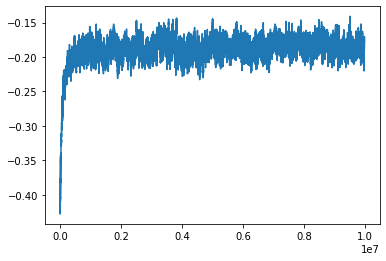

In [36]:
plt.plot(moving_average(gain, 10000))

In [38]:
dustin = QDustinPlayer(custom_env, 0.1, 0.005, 0.2)
dustin.init_random_Q()
gain = []
eval_gain = []
for _ in range(5000000):
    states, actions, rewards = dustin.run_episode()
    gain.append(rewards[-1])
for _ in range(100000):
    states, actions, rewards = dustin.evaluate_episode()
    eval_gain.append(rewards[-1])
mean_gain = np.mean(eval_gain)
print(mean_gain)

-0.06169


In [40]:
dustin = QDustinPlayer(custom_env, 0.1, 0.005, 0.1)
dustin.init_random_Q()
gain = []
eval_gain = []
for _ in range(5000000):
    states, actions, rewards = dustin.run_episode()
    gain.append(rewards[-1])
for _ in range(100000):
    states, actions, rewards = dustin.evaluate_episode()
    eval_gain.append(rewards[-1])
mean_gain = np.mean(eval_gain)
print(mean_gain)

-0.06017


In [41]:
dustin = QDustinPlayer(custom_env, 0.05, 0.005, 0.2)
dustin.init_random_Q()
gain = []
eval_gain = []
for _ in range(5000000):
    states, actions, rewards = dustin.run_episode()
    gain.append(rewards[-1])
for _ in range(100000):
    states, actions, rewards = dustin.evaluate_episode()
    eval_gain.append(rewards[-1])
mean_gain = np.mean(eval_gain)
print(mean_gain)

-0.07001


## Выводы пункт 3

Средний проигрыш Дастина (с параметрами epsilon=0.1, lr=0.005, gamma=0,1) 0.06017 <br>

По ходу доработок качество улучшалось <br>
Видно что у Дастина есть потенциал судя по последним попыткам тюнинга. К сожалению не хватает времени попробовать дотюнить до чего-нибудь близкого к 0

# end